# Remote Sensing - Exploring Black Marble Imagery at Penn State

## Environment Setup

### Import Packages

In [1]:
# Import packages
import os
import re # in radiance.py
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np # in radiance.py
import pandas as pd # in radiance.py
from pandas.io.json import json_normalize # in radiance.py
import rasterio as rio # in radiance.py
from rasterio.plot import plotting_extent
from rasterio.transform import from_origin
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.mask as em # in radiance.py
import radiance as rd

### Set Package Options

In [2]:
# Set options
sns.set(font_scale=1.5)
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Define Functions

Defined in `radiance.py`

### Set Working Directory

In [3]:
# Set working directory
working_directory = os.path.join(
    et.io.HOME, "PSU", "08-covid19-remote-sensing-fusion",
    "00-git-repos", "penn-state-radiance")

## Data Preparation

### Define File Paths

In [12]:
# Set path to radiance files
radiance_directory = os.path.join(
    working_directory, "02-raw-data", "PSU_BlackMarble_FallSemester2018_Onwards")

psu_lat_lon_path = os.path.join(
    radiance_directory, "PSU_Pixel_LatLongs.csv")

psu_radiance_path = os.path.join(
    radiance_directory, "PSU_Radiance_RavelOrderF_3.csv")

psu_cloud_mask_path = os.path.join(
    radiance_directory, "PSU_CloudMask_RavelOrderF_3.csv")

In [13]:
# Check that all paths to files exist
for path in [psu_lat_lon_path, psu_radiance_path, psu_cloud_mask_path]:
    print(f"Path exists: {path}") if os.path.exists(
        path) else print(f"Path does not exist: {path}")

Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\PSU_BlackMarble_FallSemester2018_Onwards\PSU_Pixel_LatLongs.csv
Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\PSU_BlackMarble_FallSemester2018_Onwards\PSU_Radiance_RavelOrderF_3.csv
Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\PSU_BlackMarble_FallSemester2018_Onwards\PSU_CloudMask_RavelOrderF_3.csv


### Read CSV Files to Geodataframes

In [14]:
# Read lat/lon into dataframe
psu_lat_lon_df = pd.read_csv(psu_lat_lon_path)

In [15]:
# Display dataframe
psu_lat_lon_df.head()

,ID,Latitude,Longitude
0,0,40.829917,-77.937355
1,1,40.825751,-77.937355
2,2,40.821584,-77.937355
3,3,40.817417,-77.937355
4,4,40.813251,-77.937355


In [16]:
# Read radiance values to dataframe
psu_radiance_df = pd.read_csv(psu_radiance_path)

In [17]:
psu_radiance_df.head()

,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,2018-09-11,2018-09-12,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22,2018-09-23,2018-09-24,2018-09-25,2018-09-26,2018-09-27,2018-09-28,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08,2018-10-09,2018-10-10,2018-10-11,2018-10-12,2018-10-13,2018-10-14,2018-10-15,2018-10-16,2018-10-17,2018-10-18,2018-10-19,2018-10-20,2018-10-21,2018-10-22,2018-10-23,2018-10-24,2018-10-25,2018-10-26,2018-10-27,2018-10-28,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,2018-11-11,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-17,2018-11-18,2018-11-19,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-20,2019-06-21,2019-06-22,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-03,2019-07-04,2019-07-06,2019-07-07,2019-07-08,2019-07-11,2019-07-12,2019-07-14,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-20,2019-07-21,2019-07-22,2019-07-23,2019-07-24,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-31,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-28,2019-08-29,2019-08-30,2019-08-31,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-17,2019-09-18,2019-0

In [19]:
# Read cloud mask values to dataframe
psu_cloud_mask_df = pd.read_csv(psu_cloud_mask_path)

In [20]:
psu_cloud_mask_df.head()

,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,2018-09-11,2018-09-12,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22,2018-09-23,2018-09-24,2018-09-25,2018-09-26,2018-09-27,2018-09-28,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08,2018-10-09,2018-10-10,2018-10-11,2018-10-12,2018-10-13,2018-10-14,2018-10-15,2018-10-16,2018-10-17,2018-10-18,2018-10-19,2018-10-20,2018-10-21,2018-10-22,2018-10-23,2018-10-24,2018-10-25,2018-10-26,2018-10-27,2018-10-28,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,2018-11-11,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-17,2018-11-18,2018-11-19,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-20,2019-06-21,2019-06-22,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-03,2019-07-04,2019-07-06,2019-07-07,2019-07-08,2019-07-11,2019-07-12,2019-07-14,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-20,2019-07-21,2019-07-22,2019-07-23,2019-07-24,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-31,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-28,2019-08-29,2019-08-30,2019-08-31,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-17,2019-09-18,2019-0

### Add Missings Dates and Data

Keep it indexed by pixel in order to easily call time series for one pixel. Also add Lat/Lon to it in case there is a need to call based on Lat/Long or to plot with data.

Get a plot with the pixel id in order to more easily call specific pixels or groups of pixels.

Data converted from type *int* to type *float* by within the add missing data function.

In [23]:
# Get filled radiance data (dates specified by user)
psu_radiance_filled = rd.add_missing_data(
    psu_radiance_df, '2018-09-01', '2020-05-07')

In [24]:
# Display dataset with filled data (NaN)
psu_radiance_filled.head()

,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,2018-09-11,2018-09-12,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22,2018-09-23,2018-09-24,2018-09-25,2018-09-26,2018-09-27,2018-09-28,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08,2018-10-09,2018-10-10,2018-10-11,2018-10-12,2018-10-13,2018-10-14,2018-10-15,2018-10-16,2018-10-17,2018-10-18,2018-10-19,2018-10-20,2018-10-21,2018-10-22,2018-10-23,2018-10-24,2018-10-25,2018-10-26,2018-10-27,2018-10-28,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,2018-11-11,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-17,2018-11-18,2018-11-19,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-16,2019-06-17,2019-06-18,2019-06-19,2019-06-20,2019-06-21,2019-06-22,2019-06-23,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-02,2019-07-03,2019-07-04,2019-07-05,2019-07-06,2019-07-07,2019-07-08,2019-07-09,2019-07-10,2019-07-11,2019-07-12,2019-07-13,2019-07-14,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-20,2019-07-21,2019-07-22,2019-07-23,2019-07-24,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-30,2019-07-31,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-13,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-0

In [25]:
# Get filled cloud mask data
psu_cloud_mask_filled = rd.add_missing_data(
    psu_cloud_mask_df, '2018-09-01', '2020-05-07')

In [26]:
# Display filled dataset with filled data (NaN)
psu_cloud_mask_filled.head()

,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,2018-09-11,2018-09-12,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22,2018-09-23,2018-09-24,2018-09-25,2018-09-26,2018-09-27,2018-09-28,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08,2018-10-09,2018-10-10,2018-10-11,2018-10-12,2018-10-13,2018-10-14,2018-10-15,2018-10-16,2018-10-17,2018-10-18,2018-10-19,2018-10-20,2018-10-21,2018-10-22,2018-10-23,2018-10-24,2018-10-25,2018-10-26,2018-10-27,2018-10-28,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,2018-11-11,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-17,2018-11-18,2018-11-19,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-16,2019-06-17,2019-06-18,2019-06-19,2019-06-20,2019-06-21,2019-06-22,2019-06-23,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-02,2019-07-03,2019-07-04,2019-07-05,2019-07-06,2019-07-07,2019-07-08,2019-07-09,2019-07-10,2019-07-11,2019-07-12,2019-07-13,2019-07-14,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-20,2019-07-21,2019-07-22,2019-07-23,2019-07-24,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-30,2019-07-31,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-13,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-0

Is there a way to mask the full dataframe, instead of calling individual months days first? This way, the pre-processing is up front?

Implement something similar to monthly, where user enters date range (radiance and mask data), and the function masks data and stores the masked array in a dictionary?

In [ ]:
# Get radiance data for one pixel (Sept 2019 - April 2020)
pixel_id_0_radiance = psu_radiance_filled.loc[0]

In [ ]:
# Get cloud mask data for one pixel (Sept 2019 - April 2020)
pixel_id_0_mask = psu_cloud_mask_filled.loc[[0]]

In [ ]:
# Plot single-pixel time series
with plt.style.context('dark_background'):
    
    ax = pixel_id_0_radiance.plot(figsize=(16,6), grid=False, color='#ff7f00', linewidth=2)
    
    ax.set_title('Penn State Campus - Single-Pixel Time Series\nPixel ID 0 - Longitude: -77.937355, Latitude: 40.829917')
    ax.set_xlabel('Date')
    ax.set_ylabel('Unmasked Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)')

In [ ]:
# # Note - Change date format (both now YYYY-MM-DD)
# #  makes the get cloud_mask_data() function not needed;
# #  both can use the get_radiance_data() function

# # Get Sept 2019 radiance value dataframes into list - FILLED
# sept_2019_radiance_filled = get_radiance_data(
#     psu_radiance_filled, year='2019', month='09')

# # Get Sept 2019 cloud mask dataframes into list - FILLED
# sept_2019_mask_filled = get_radiance_data(
#     psu_cloud_mask_filled, year='2019', month='09')

In [ ]:
# sept_2019_radiance_filled[0].head()

In [ ]:
# sept_2019_mask_filled[0].head()

In [ ]:
# # Calculate mean radiance with filled data
# sept_2019_mean_radiance_filled = calculate_mean_radiance(
#     sept_2019_radiance_filled, sept_2019_mask_filled)

In [ ]:
# # Confirm mean radiance (should be 611.1739)
# sept_2019_mean_radiance_filled.max()

### Create Plotting Extent

In [258]:
def create_plotting_extent(study_area, longitude_column, latitude_column):
    """Creates a plotting extent from a
    dataframe containing pixel lat/lon values.

    Intended for use with plotting and exporting
    numpy array values, with spatial properties.

    Parameters
    ----------
    study_area : pandas dataframe
        Dataframe containing lat/lon values
        for all pixels in the study area.

    longitude_column : str
        Name of the column containing longitude 
        values.

    latitude_column : str
        Name of the column containing latitude 
        values.

    Returns
    ------
    extent : tuple (of float)
        Tuple (left, right, bottom, top) of the
        study area bounds.

    Example
    -------
        >>>
        >>>
        >>>
        >>>
    """
    # Get number pixels in study area
    num_pixels = len(study_area.index)

    # Get number of rows in study area (unique latitude values)
    num_rows = len(study_area[latitude_column].unique())

    # Get number of columns in study area (unique longitude values)
    num_columns = len(study_area[longitude_column].unique())

    # Get min/max longitude and latitude values
    longitude_min = study_area[longitude_column].min()
    longitude_max = study_area[longitude_column].max()
    latitude_min = study_area[latitude_column].min()
    latitude_max = study_area[latitude_column].max()

    # Get the spacing between rows (latitude spacing)
    row_spacing = (latitude_max - latitude_min) / (num_rows - 1)

    # Get the spacing between columns (longitude spacing)
    column_spacing = (longitude_max - longitude_min) / (num_columns - 1)

    # Define extent (lat/lon as top-left corner of pixel)
    extent = (
        longitude_min,
        longitude_max + column_spacing,
        latitude_min - row_spacing,
        latitude_max
    )

    # Define transform (top-left corner: west, north, and pixel sizes: xsize, ysize)
    transform = from_origin(
        longitude_min, latitude_max, column_spacing, row_spacing)

    # Return extent
    return extent, transform

In [238]:
# Create PSU extent
psu_extent = create_plotting_extent(
    study_area=psu_lat_lon_df, 
    longitude_column='Longitude', 
    latitude_column='Latitude')
psu_extent

(-77.93943837333333, -77.77277170666667, 40.75700065647059, 40.83200066352941)

In [239]:
# Get number pixels in study area
num_pixels = len(psu_lat_lon_df.index)
num_pixels

720

In [240]:
# Get number of rows in study area (unique Latitude values)
num_rows = len(psu_lat_lon_df.Latitude.unique())
num_rows

18

In [241]:
# Get number of columns in study area (unique Longitude values)
num_columns = len(psu_lat_lon_df.Longitude.unique())
num_columns

40

In [244]:
# # Spacing between pixels is (max - min) / (num_points - 1)
# # Get spacing for extent (assume consistent spacing between points)
# lon_spacing = (lon_max - lon_min) / 39
# lat_spacing = (lat_max - lat_min) / 17

In [243]:
# Get min/max longitude and latitude values
lon_min = psu_lat_lon_df.Longitude.min()
lon_max = psu_lat_lon_df.Longitude.max()
lat_min = psu_lat_lon_df.Latitude.min()
lat_max = psu_lat_lon_df.Latitude.max()

In [245]:
# Display values
print(f"Lon min: {lon_min}\nLon max: {lon_max}\nLat min: {lat_min}\nLat max: {lat_max}")

Lon min: -77.93735504
Lon max: -77.77485504
Lat min: 40.75908399
Lat max: 40.82991733


In [246]:
# Get spacing for extent (assume lat/lon are centroids)
lon_spacing = (lon_max - lon_min) / 39
lat_spacing = (lat_max - lat_min) / 17

# Check to which decimal the lat and long spacings match
round(lon_spacing, 9) == round(lon_spacing, 9)

# Define single spacing
coord_spacing = round(lon_spacing, 9)

In [247]:
lat_spacing, lon_spacing

(0.004166667058823534, 0.004166666666666521)

In [248]:
# Define extent
psu_extent = (
    lon_min - coord_spacing/2,
    lon_max + coord_spacing/2,
    lat_min - coord_spacing/2,
    lat_max + coord_spacing/2
)

In [249]:
# # Define extent
# psu_extent = (lon_min-0.004166999999995369/2, 
#               lon_max+0.004166999999995369/2, 
#               lat_min-0.004166999999995369/2, 
#               lat_max+0.004166999999995369/2)

In [250]:
# Show pre-padding extent
(lon_min, lon_max, lat_min, lat_max)

(-77.93735504, -77.77485504, 40.75908399, 40.82991733)

In [251]:
# Show extent (xmin, xmax, ymin, ymax)
psu_extent

(-77.9394383735, -77.77277170650001, 40.7570006565, 40.832000663500004)

In [252]:
# Coords for export, max x value
export_west_coord = psu_extent[0]
export_north_coord = psu_extent[3]

In [253]:
# Coords for export, max y value
y_max = psu_extent[3]
y_max

40.832000663500004

In [254]:
# Create geodataframe to store lat/lon points 
#  (for plotting over array)
psu_lat_lon_copy = psu_lat_lon_df.copy()

psu_lat_lon_gdf = gpd.GeoDataFrame(
    psu_lat_lon_copy, 
    crs="epsg:4326", 
    geometry=gpd.points_from_xy(
        psu_lat_lon_copy.Longitude, 
        psu_lat_lon_copy.Latitude)
)

In [255]:
# Display dataframe
psu_lat_lon_gdf.head()

,ID,Latitude,Longitude,geometry
0,0,40.829917,-77.937355,POINT (-77.93736 40.82992)
1,1,40.825751,-77.937355,POINT (-77.93736 40.82575)
2,2,40.821584,-77.937355,POINT (-77.93736 40.82158)
3,3,40.817417,-77.937355,POINT (-77.93736 40.81742)
4,4,40.813251,-77.937355,POINT (-77.93736 40.81325)


## Data Processing

Workflow for storing data in dictionary:

* Define list of dates that for data that will be added to the dictionary
    * ```python
    date_list = get_date_list(
        start_date='2019-09-01', 
        end_date='2020-04-30')
    ```

* Store data in dictionary
    * ```python
    store_daily_radiance(
        filled_radiance_data, 
        filled_cloud_mask_data, 
        date_list)
    ```
    * For each date in the date list:
        * Finds the date in the dataframe based on column name
        * Creates a correctly formatted (shaped) array for that data (values and cloud mask)
        * Masks if cloud mask values are present
        * Adds year/month/day index to dictionary as key and masked array as value


Workflow for accessing/extracting data from dictionary:

    * Call individual day via dictionary index
        * dictionary[YYYY][MM][DD] (returns array)
        * 
        
    * Call one month of data
        * dictionary[YYYY][MM][DD] (returns dictionary of arrays, with days as keys.
        * To get a list, use flatten_month() function
        
    * Call intra or inter-month data
        * get_date_list()
        * get_array_data_from_dict()
        * calculate_mean_radiance()


    * Define list of dates that for data that will be added to the dictionary
    * ```python
        date_list = get_date_list(
        start_date='2019-09-01', 
        end_date='2020-04-30')
 ```

Crate function for plotting?

* Get a d


Get daily data into a dictionary, for retrieval several different aggregation levels:

* Daily
* Monthly 
* Ranges of dates (in-between months)

Where data is centrally stored and many functions can act upon that data to run calculations.

1. Read data to dataframes

2. Add missing values

3. Create date list for looping through to pull radiance data (values and cloud mask)
    * *get_date_list()*
    

4. Store daily data in dictionary
    * *store_daily_radiance()*
    * ```python
    radiance_dict['Year']['Month']['Day']
    ```


5. Access values
    * Directly from dictionary for single days
    * Directly from dictionary for whole month data (to then average)
    * With the function *get_array_data_from_dict()* and input dictionary and date list for cross-month date list and/or specialized date list (weekly on Sundays, etc.) (offsets and/or anchored offsets)
        * https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
        
        
Should also do functions/workflow for individual pixel-based time series.

### Store Daily Radiance Values

In [133]:
# Get list of dates (daily) from Sept 1, 2018 to May 7, 2020
date_list = rd.create_date_list(start_date='2018-09-01', end_date='2020-05-07')

In [32]:
# Display number of days in list
len(date_list)

608

In [134]:
# Store all daily filled values in nested dictionary
#  (indexed by [Year][Month][Day])
radiance_sept_2018_may_2020 = rd.store_data(
    psu_radiance_filled, psu_cloud_mask_filled, 
    mask_value=100, array_shape=(18, 40), dates=date_list)

### Calculate and Store Monthly Means

In [135]:
# Define year/month tuples to loop through
months = [
    ('2018', '09'),
    ('2018', '10'),
    ('2018', '11'),
    ('2018', '12'),
    ('2019', '01'),
    ('2019', '02'),
    ('2019', '03'),
    ('2019', '04'),
    ('2019', '05'),
    ('2019', '06'),
    ('2019', '07'),
    ('2019', '08'),
    ('2019', '09'),
    ('2019', '10'),
    ('2019', '11'),
    ('2019', '12'),
    ('2020', '01'),
    ('2020', '02'),
    ('2020', '03'),
    ('2020', '04')
]

In [136]:
# Initialize dictionary to store monthly mean radiance arrays
radiance_monthtly_mean = {}

# Loop through all months
for year, month in months:
    
     # Add year to dictionary if not existing key
    if year not in radiance_monthtly_mean.keys():
        radiance_monthtly_mean[year] = {}

    # Get dictionary of monthly arrays
    radiance_dict = radiance_sept_2018_may_2020.get(year).get(month)

    # Flatten dictionary to list of arrays
    radiance_arrays = rd.flatten_data(radiance_dict)
    
    # Calculate mean of arrays
    radiance_mean = rd.calculate_mean(radiance_arrays)

    # Add mean array to dictionary
    radiance_monthtly_mean[year][month] = radiance_mean

In [137]:
# Show top-level keys (years)
radiance_monthtly_mean.keys()

dict_keys(['2018', '2019', '2020'])

In [138]:
# Show 2018 keys (months)
radiance_monthtly_mean.get('2018').keys()

dict_keys(['09', '10', '11', '12'])

In [139]:
# Show 2019 keys (months)
radiance_monthtly_mean.get('2019').keys()

dict_keys(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

In [140]:
# Show 2020 keys (months)
radiance_monthtly_mean.get('2020').keys()

dict_keys(['01', '02', '03', '04'])

In [141]:
# Get min and max values for September 2019 mean
print(f"Min Radiance, Sept 2019 Mean Values: {radiance_monthtly_mean.get('2019').get('09').min()}")
print(f"Max Radiance, Sept 2019 Mean Values: {radiance_monthtly_mean.get('2019').get('09').max()}")

Min Radiance, Sept 2019 Mean Values: 21.565217391304348
Max Radiance, Sept 2019 Mean Values: 611.1739130434783


In [142]:
# Get min and max values for March 2020 mean
print(f"Min Radiance, March 2020 Mean Values: {radiance_monthtly_mean.get('2020').get('03').min()}")
print(f"Max Radiance, March 2020 Mean Values: {radiance_monthtly_mean.get('2020').get('03').max()}")

Min Radiance, March 2020 Mean Values: 21.741935483870968
Max Radiance, March 2020 Mean Values: 430.03225806451616


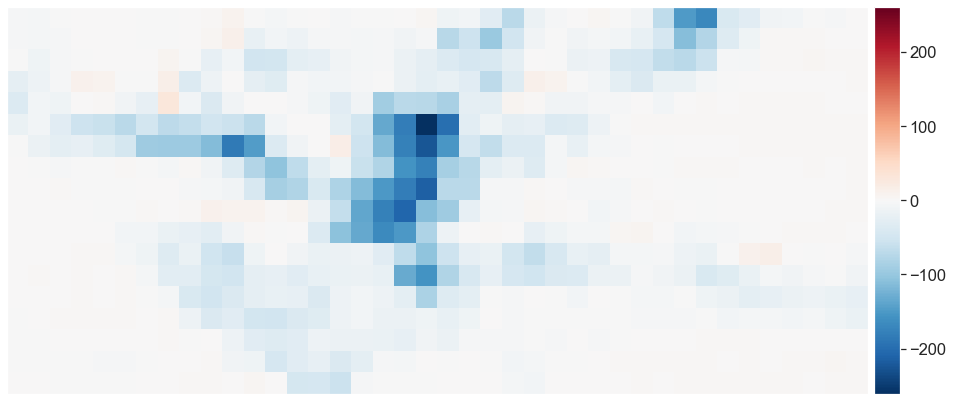

In [143]:
# Calculate Sept 2019 to March 2020 difference
diff_sept_2019_march_2020 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2020').get('03'),
    radiance_monthtly_mean.get('2019').get('09'))

# Plot difference from Sept 2019 to March 2020
ep.plot_bands(
    diff_sept_2019_march_2020, 
    scale=False, 
    vmin=diff_sept_2019_march_2020.min(),
    vmax=-diff_sept_2019_march_2020.min(),
    cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

#### Differences from Baseline (Pre-COVID to COVID)

In [144]:
# import numpy.ma as ma

# test = radiance_sept_2018_apr_2020.get('2019').get('09')

# # Count number of missing days
# for key in test.keys():
# #     print(test.get(key))
#     if np.isnan(np.sum(test.get(key))):
#         print(f"Sept {key} - Contains NaN - Missing Data")
# #     print(test.get(key)).count()
#     print(key, type(test.get(key)))
#     if isinstance(test.get(key), np.ma.core.MaskedArray):
#         print(key)
#         count = test.get(key).count()
#         print("Number of pixels masked (out of 720 total):", count)
        

# # Need to also count the number of fully masked arrays in month?

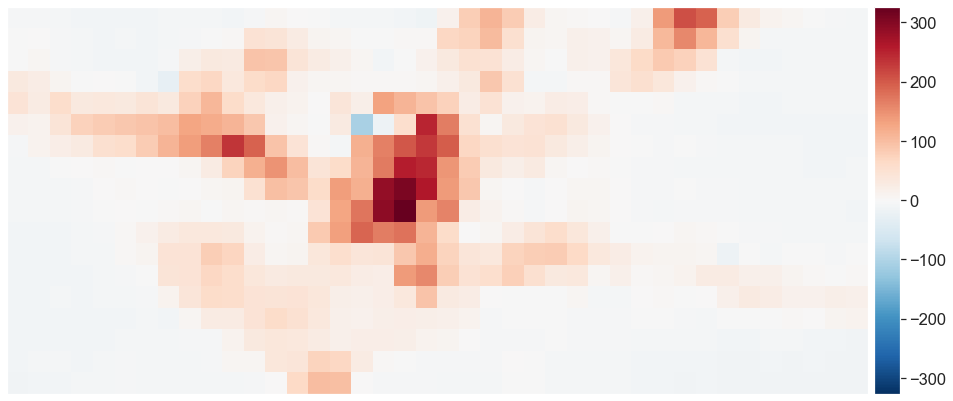

In [145]:
# Calculate September 2018 to September 2019 difference
diff_sep_2018_sep_2019 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2019').get('09'),
    radiance_monthtly_mean.get('2018').get('09'))

# Plot difference from September 2018 to September 2019
ep.plot_bands(
    diff_sep_2018_sep_2019, 
    scale=False, 
#     vmin=-200,
#     vmax=200,
    vmin=-diff_sep_2018_sep_2019.max(),
    vmax=diff_sep_2018_sep_2019.max(),
    cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

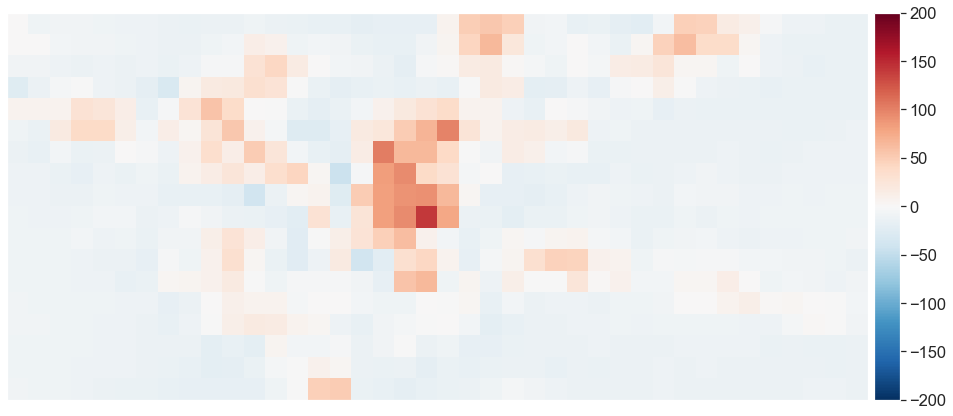

In [146]:
# Calculate October 2018 to October 2019 difference
diff_oct_2018_oct_2019 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2019').get('10'),
    radiance_monthtly_mean.get('2018').get('10'))

# Plot difference from October 2018 to October 2019 
ep.plot_bands(
    diff_oct_2018_oct_2019, 
    scale=False, 
    vmin=-200,
    vmax=200,
#     vmin=-diff_oct_2018_oct_2019.max(),
#     vmax=diff_oct_2018_oct_2019.max(),
    cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

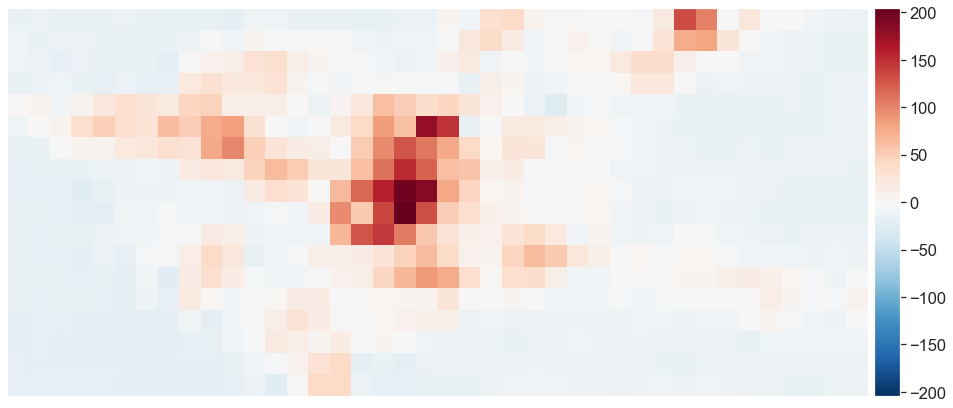

In [147]:
# Calculate November 2018 to November 2019 difference
diff_nov_2018_nov_2019 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2019').get('11'),
    radiance_monthtly_mean.get('2018').get('11'))

# Plot difference from November 2018 to November 2019
ep.plot_bands(
    diff_nov_2018_nov_2019, 
    scale=False, 
#     vmin=-200,
#     vmax=200,
    vmin=-diff_nov_2018_nov_2019.max(),
    vmax=diff_nov_2018_nov_2019.max(),
    cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

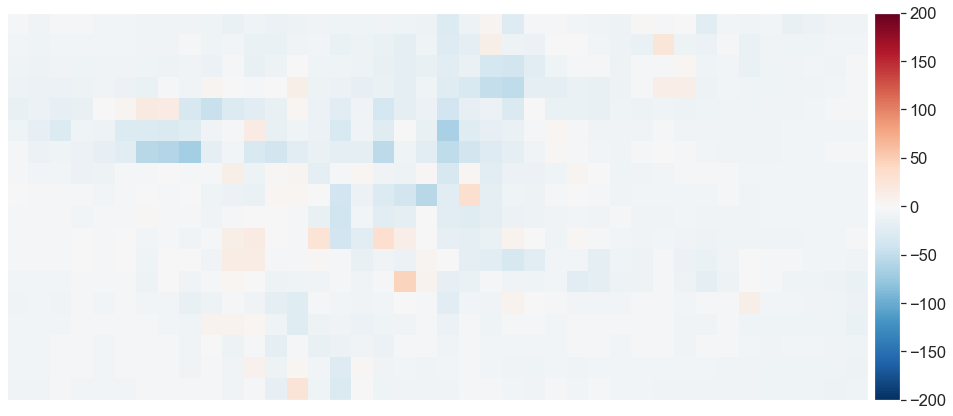

In [148]:
# Calculate December 2018 to December 2019 difference
diff_dec_2018_dec_2019 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2019').get('12'),
    radiance_monthtly_mean.get('2018').get('12'))

# Plot difference from December 2018 to December 2019
ep.plot_bands(
    diff_dec_2018_dec_2019, 
    scale=False, 
    vmin=-200,
    vmax=200,
#     vmin=diff_dec_2018_dec_2019.min(),
#     vmax=-diff_dec_2018_dec_2019.min(),
    cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

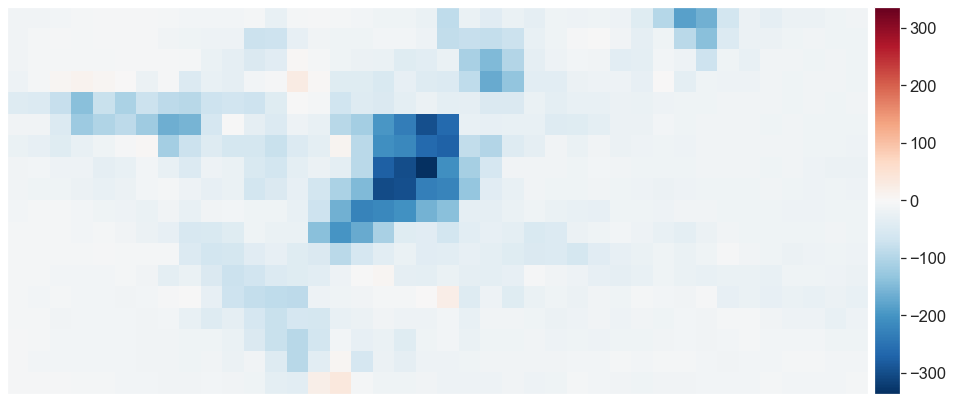

In [149]:
# Calculate January 2019 to January 2020 difference
diff_jan_2019_jan_2020 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2020').get('01'),
    radiance_monthtly_mean.get('2019').get('01'))

# Plot difference from January 2019 to January 2020
ep.plot_bands(
    diff_jan_2019_jan_2020, 
    scale=False, 
    vmin=diff_jan_2019_jan_2020.min(),
    vmax=-diff_jan_2019_jan_2020.min(),
    cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

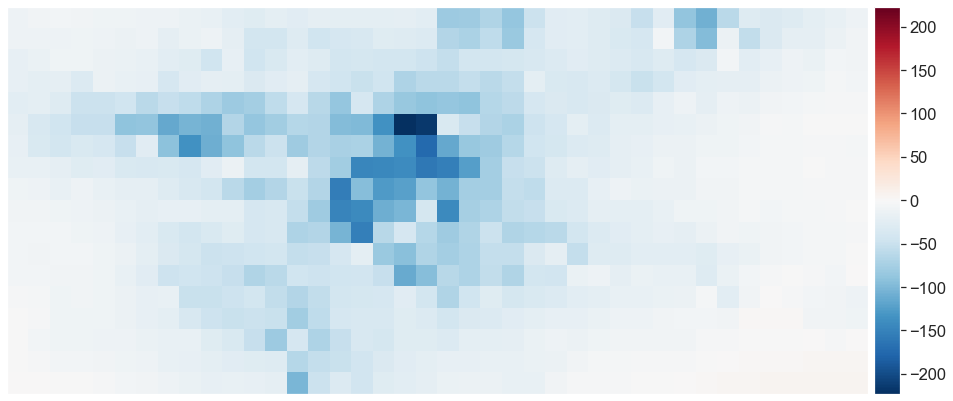

In [150]:
# Calculate February 2019 to February 2020 difference
diff_feb_2019_feb_2020 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2020').get('02'),
    radiance_monthtly_mean.get('2019').get('02'))

# Plot difference from February 2019 to February 2020
ep.plot_bands(
    diff_feb_2019_feb_2020, 
    scale=False, 
    vmin=diff_feb_2019_feb_2020.min(),
    vmax=-diff_feb_2019_feb_2020.min(),
    cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

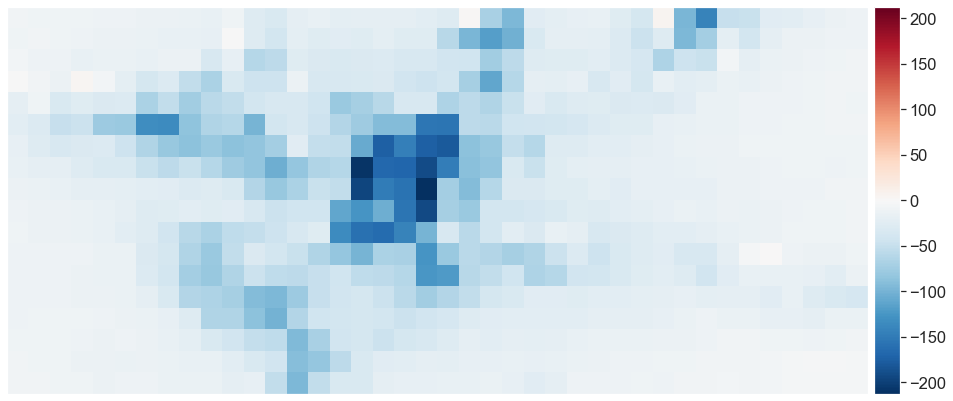

In [151]:
# Calculate March 2019 to March 2020 difference
diff_march_2019_march_2020 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2020').get('03'),
    radiance_monthtly_mean.get('2019').get('03'))

# Plot difference from March 2019 to March 2020
ep.plot_bands(
    diff_march_2019_march_2020, 
    scale=False, 
    vmin=diff_march_2019_march_2020.min(),
    vmax=-diff_march_2019_march_2020.min(),
    cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

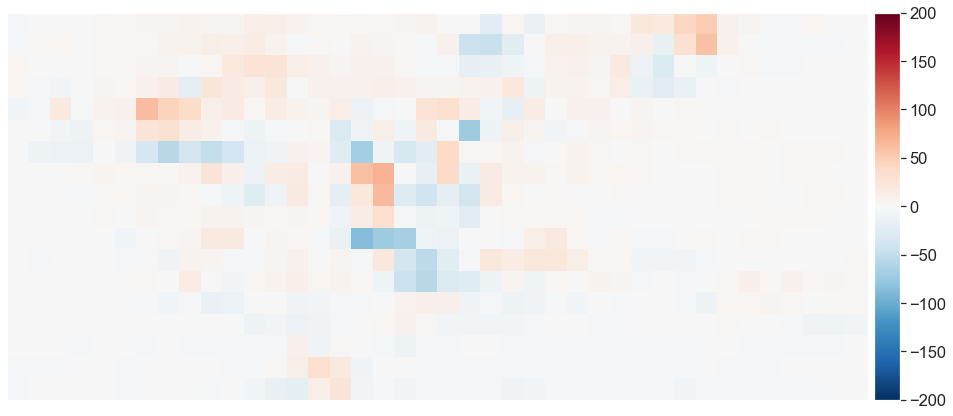

In [152]:
# Calculate April 2019 to April 2020 difference
diff_april_2019_april_2020 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2020').get('04'),
    radiance_monthtly_mean.get('2019').get('04'))

# Plot difference from April 2019 to April 2020
ep.plot_bands(
    diff_april_2019_april_2020, 
    scale=False, 
    vmin=-200,
    vmax=200,
#     vmin=diff_april_2019_april_2020.min(),
#     vmax=-diff_april_2019_april_2020.min(),
    cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

#### Date Range Means

PSU Academic Calendars

http://www.registrar.psu.edu/academic-calendars/

http://www.registrar.psu.edu/academic-calendars/2018-19.cfm

http://www.registrar.psu.edu/academic-calendars/2019-20.cfm

In [160]:
# Define date ranges to loop through
date_ranges = [
    
    # 2018-2019 academic year
    # Labor day weekend to commencement weekend (includes day after commencement)
    rd.create_date_list('2018-09-01', '2018-12-16'),
    
    # Thanksgiving holiday
    rd.create_date_list('2018-11-18', '2018-11-24'),
    
    # Fall study days & final exam week
    rd.create_date_list('2018-12-08', '2018-12-14'),
    
    # After Fall commencement to before Spring new student arrival
    rd.create_date_list('2018-12-17', '2019-01-04'),
    
    # Spring new student arrival to Spring commencement (commencement weekend)
    rd.create_date_list('2019-01-05', '2019-05-05'),
    
    # Spring break
    rd.create_date_list('2019-03-03', '2019-03-09'),
    
    # Spring study days & final exam week
    rd.create_date_list('2019-04-27', '2019-05-03'),
    
    # Maymester (excluding arrival day, which occurs on Spring commencement)
    rd.create_date_list('2019-05-06', '2019-06-05'),
    
    # Summer session (regular) through commencement (includes day after commencement)
    rd.create_date_list('2019-05-12', '2019-08-11'),
    
    
    # 2019-2020 academic year
    # Fall new student arrival to commencement weekend (includes day after commencement)
    rd.create_date_list('2019-08-23', '2019-12-22'),
    
    # Labor day weekend to Commencement weekend (includes day after commencement)
    rd.create_date_list('2019-08-31', '2019-12-22'),
        
    # Thanksgiving holiday
    rd.create_date_list('2019-11-24', '2019-11-30'),
    
    # Fall study days & final exam week
    rd.create_date_list('2019-12-14', '2019-12-20'),
    
    # After Fall commencement to before Spring new student arrival
    rd.create_date_list('2019-12-23', '2020-01-10'),
    
    # Spring new student arrival to Spring commencement (commencement weekend)
    rd.create_date_list('2020-01-11', '2020-05-10'),
    
    # Spring break
    rd.create_date_list('2020-03-08', '2020-03-14'),
    
    # Spring study days & final exam week
    rd.create_date_list('2020-05-02', '2020-05-08'),
    
#     # Maymester (excluding arrival day, which occurs on Spring commencement)
#     rd.create_date_list('2020-05-11', '2020-06-10'),
    
#     # Summer session (regular) through commencement (includes day after commencement)
#     rd.create_date_list('2020-05-18', '2020-08-15')
]

In [164]:
# Initialize dictionary to store monthly mean radiance arrays
radiance_sept_2018_may_2020_dict = {}

# Loop through all months
for date_range in date_ranges:
    
    # Create index based on date range
    date_key = date_range[0].replace('-', '') + '-' + date_range[-1].replace('-', '')
    
    # Get array for each date into list
    radiance_arrays = rd.extract_data(
        radiance=radiance_sept_2018_may_2020, dates=date_range)
    
    # Calculate mean of arrays
    radiance_mean = rd.calculate_mean(radiance_arrays)

    # Add mean array to dictionary
    if date_key not in radiance_sept_2018_may_2020_dict.keys():
        radiance_sept_2018_may_2020_dict[date_key] = radiance_mean

In [167]:
# Show date ranges (key) in dictionary
for key in radiance_sept_2018_may_2020_dict.keys():
    print(f"Key: {key}, Shape: {radiance_sept_2018_may_2020_dict.get(key).shape}")

Key: 20180901-20181216, Shape: (18, 40)
Key: 20181118-20181124, Shape: (18, 40)
Key: 20181208-20181214, Shape: (18, 40)
Key: 20181217-20190104, Shape: (18, 40)
Key: 20190105-20190505, Shape: (18, 40)
Key: 20190303-20190309, Shape: (18, 40)
Key: 20190427-20190503, Shape: (18, 40)
Key: 20190506-20190605, Shape: (18, 40)
Key: 20190512-20190811, Shape: (18, 40)
Key: 20190823-20191222, Shape: (18, 40)
Key: 20190831-20191222, Shape: (18, 40)
Key: 20191124-20191130, Shape: (18, 40)
Key: 20191214-20191220, Shape: (18, 40)
Key: 20191223-20200110, Shape: (18, 40)
Key: 20200111-20200510, Shape: (18, 40)
Key: 20200308-20200314, Shape: (18, 40)
Key: 20200502-20200508, Shape: (18, 40)


### Calculate and Store Monthly Means (Alternative Version)

In [168]:
# Define date ranges to loop through
date_ranges = [
    rd.create_date_list('2019-09-01', '2019-09-30'),
    rd.create_date_list('2019-10-01', '2019-10-31'),
    rd.create_date_list('2019-11-01', '2019-11-30'),
    rd.create_date_list('2019-12-01', '2019-12-31')
]

In [172]:
# Initialize dictionary to store monthly mean radiance arrays
radiance_mean_dict = {}

# Loop through all months
for date_range in date_ranges:
    
    # Create index based on date range
    date_key = date_range[0].replace('-', '') + '-' + date_range[-1].replace('-', '')
    
    # Get array for each date into list
    radiance_arrays = rd.extract_data(
        radiance=radiance_sept_2018_may_2020, dates=date_range)
    
    # Calculate mean of arrays
    radiance_mean = rd.calculate_mean(radiance_arrays)

    # Add mean array to dictionary
    if date_key not in radiance_mean_dict.keys():
        radiance_mean_dict[date_key] = radiance_mean

In [173]:
# Shows keys for date ranges in the dictionary
radiance_mean_dict.keys()

dict_keys(['20190901-20190930', '20191001-20191031', '20191101-20191130', '20191201-20191231'])

### Calculate and Store Date Range Means

In [174]:
# Define date ranges to loop through
date_ranges = [
    rd.create_date_list('2019-09-15', '2019-10-15'),
    rd.create_date_list('2019-12-02', '2019-12-21'),
    rd.create_date_list('2019-12-22', '2020-01-10'),
    rd.create_date_list('2020-01-11', '2020-01-30')
]

In [176]:
# Initialize dictionary to store monthly mean radiance arrays
radiance_mean_dict = {}

# Loop through all months
for date_range in date_ranges:
    
    # Create index based on date range
    date_key = date_range[0].replace('-', '') + '-' + date_range[-1].replace('-', '')
    
    # Get array for each date into list
    radiance_arrays = rd.extract_data(
        radiance=radiance_sept_2018_may_2020, dates=date_range)
    
    # Calculate mean of arrays
    radiance_mean = rd.calculate_mean(radiance_arrays)

    # Add mean array to dictionary
    if date_key not in radiance_mean_dict.keys():
        radiance_mean_dict[date_key] = radiance_mean

In [177]:
# Shows keys for date ranges in the dictionary
radiance_mean_dict.keys()

dict_keys(['20190915-20191015', '20191202-20191221', '20191222-20200110', '20200111-20200130'])

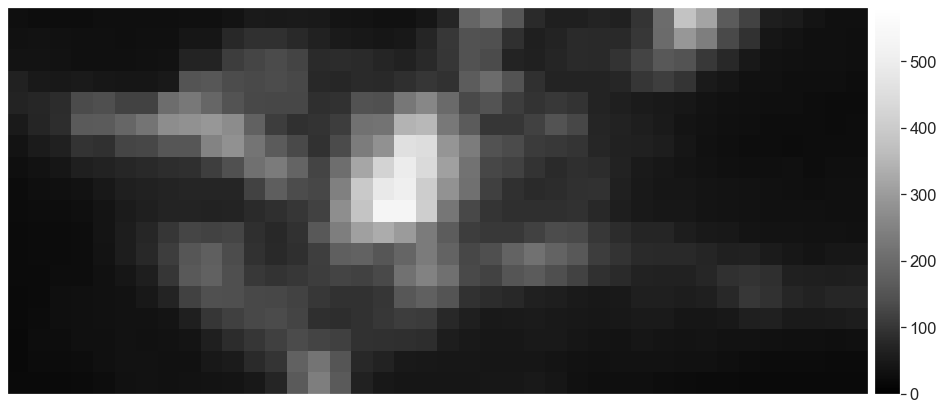

In [178]:
# Plot time period 1
ep.plot_bands(
    radiance_mean_dict.get('20191222-20200110'), 
    scale=False, 
    vmin=0,
    vmax=radiance_mean_dict.get('20200111-20200130').max(),
    #cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

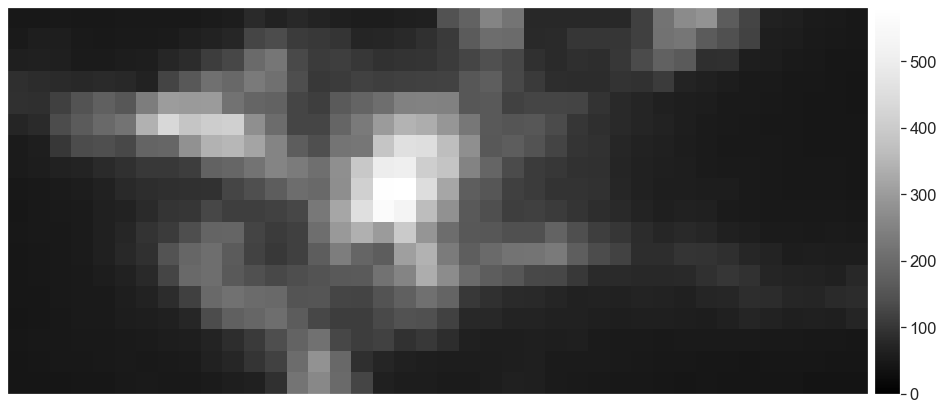

In [179]:
# Plot time period 2
ep.plot_bands(
    radiance_mean_dict.get('20200111-20200130'), 
    scale=False, 
    vmin=0,
    vmax=radiance_mean_dict.get('20200111-20200130').max(),
    #cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

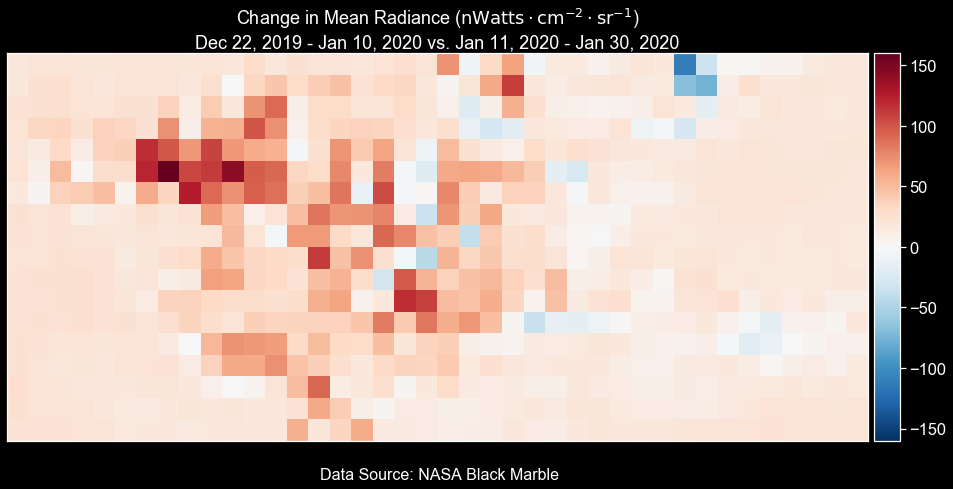

In [180]:
# Compute difference in time periods
diff = rd.subtract_arrays(
    radiance_mean_dict.get('20200111-20200130'), 
    radiance_mean_dict.get('20191222-20200110'))

with plt.style.context('dark_background'):
    
    fig, ax = plt.subplots(figsize=(16, 8))

    # Plot difference from Sept 2019 to March 2020
    ep.plot_bands(
        diff, 
        title="Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)\nDec 22, 2019 - Jan 10, 2020 vs. Jan 11, 2020 - Jan 30, 2020",
        scale=False, 
        vmin=-diff.max(),
        vmax=diff.max(),
        cmap='RdBu_r',
        ax=ax)
        #figsize=(16, 8))


    # Add caption
    fig.text(0.5, .1, "Data Source: NASA Black Marble",
             ha='center', fontsize=16)

    
plt.savefig(
    fname="penn-state-mean-radiance-change-after-dec-2019-grad.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')


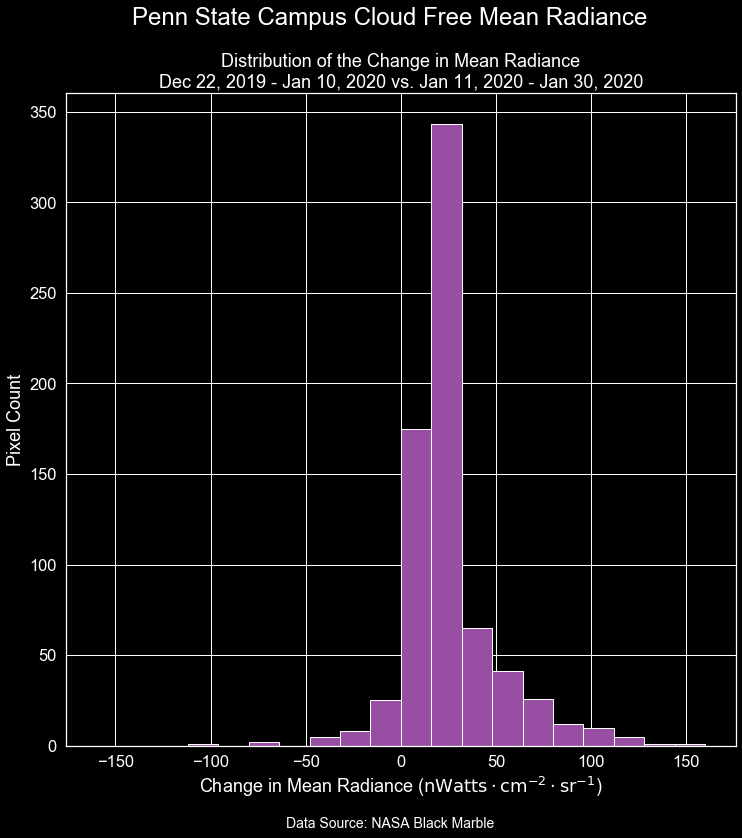

In [181]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        diff,
        hist_range=(-diff.max(), diff.max()),
        colors='#984ea3',
        title='Distribution of the Change in Mean Radiance\nDec 22, 2019 - Jan 10, 2020 vs. Jan 11, 2020 - Jan 30, 2020',
        xlabel='Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', ylabel='Pixel Count')

    plt.suptitle("Penn State Campus Cloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)
    
plt.savefig(
    fname="penn-state-mean-radiance-change-distribution-after-dec-2019-grad.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')

### Full Month - Mean (Alternative Version)

In [182]:
# Get dates from Sept 01 - Sept 30
date_list = rd.create_date_list('2019-09-01', '2019-09-30')

In [184]:
# Get array for each date into list
sept_01_sep_30_arrays = rd.extract_data(
 radiance=radiance_sept_2018_may_2020, dates=date_list)

In [185]:
# Confirm length
len(sept_01_sep_30_arrays)

30

In [186]:
# Calculate mean
sept_01_sep_30_mean = rd.calculate_mean(sept_01_sep_30_arrays)

In [187]:
# Get min and max values for mean
print(f"Min: {sept_01_sep_30_mean.min()}")
print(f"Max: {sept_01_sep_30_mean.max()}")

Min: 21.565217391304348
Max: 611.1739130434783


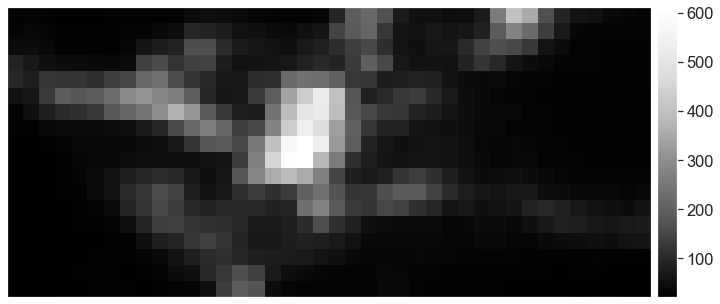

In [188]:
# Plot
ep.plot_bands(sept_01_sep_30_mean, scale=False, vmax=sept_01_sep_30_mean.max())

plt.show()

### Intra-Month Range - Mean

In [195]:
# Get dates from Sept 10 - Sept 20
date_list = rd.create_date_list('2019-09-10', '2019-09-20')

In [196]:
# Get array for each date into list
sept_10_sep_20_arrays = rd.extract_data(
 radiance=radiance_sept_2018_may_2020, dates=date_list)

In [197]:
# Confirm length
len(sept_10_sep_20_arrays)

11

In [198]:
# Calculate mean
sept_10_sep_20_mean = rd.calculate_mean(sept_10_sep_20_arrays)

In [199]:
# Get min and max values for mean
print(f"Min: {sept_10_sep_20_mean.min()}")
print(f"Max: {sept_10_sep_20_mean.max()}")

Min: 46.0
Max: 541.0


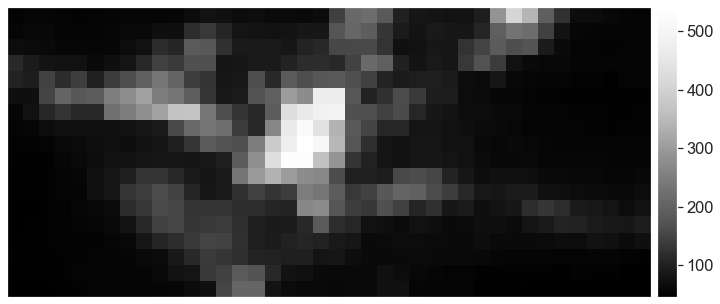

In [200]:
# Plot
ep.plot_bands(sept_10_sep_20_mean, scale=False, vmax=sept_10_sep_20_mean.max())

plt.show()

### Inter-Month Continuous Range - Mean

In [ ]:
# Get dates from Sept 15 - Oct 15
date_list = rd.create_date_list('2019-09-15', '2019-10-15')

In [201]:
# Get array for each date into list
sept_15_oct_15_arrays = rd.extract_data(
    radiance=radiance_sept_2018_may_2020, dates=date_list)

In [202]:
# Confirm length
len(sept_15_oct_15_arrays)

11

In [203]:
# Calculate mean
sept_15_oct_15_mean = rd.calculate_mean(sept_15_oct_15_arrays)

In [204]:
# Get min and max values for mean
print(f"Min: {sept_15_oct_15_mean.min()}")
print(f"Max: {sept_15_oct_15_mean.max()}")

Min: 46.0
Max: 541.0


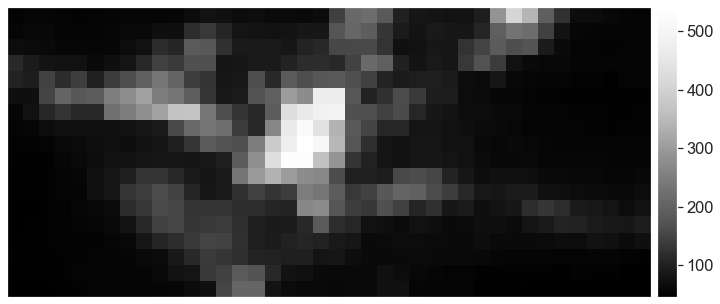

In [205]:
# Plot
ep.plot_bands(sept_15_oct_15_mean, scale=False, vmax=sept_15_oct_15_mean.max())

plt.show()

### Multiple Full Months - Mean

In [206]:
# Get dates from Dec 01 2019 - Jan 31 2020
date_list = rd.create_date_list('2019-12-01', '2020-01-31')

In [208]:
# Get array for each date into list
dec_2019_jan_2020_arrays = rd.extract_data(
    radiance=radiance_sept_2018_may_2020, dates=date_list)

In [209]:
# Confirm length
len(dec_2019_jan_2020_arrays)

62

In [210]:
# Calculate mean
dec_2019_jan_2020_mean = rd.calculate_mean(dec_2019_jan_2020_arrays)

In [211]:
# Get min and max values for mean
print(f"Min: {dec_2019_jan_2020_mean.min()}")
print(f"Max: {dec_2019_jan_2020_mean.max()}")

Min: 40.30508474576271
Max: 457.08474576271186


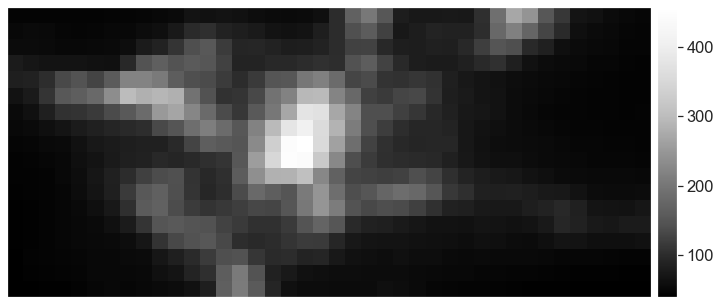

In [212]:
# Plot
ep.plot_bands(dec_2019_jan_2020_mean, scale=False, vmax=dec_2019_jan_2020_mean.max())

plt.show()

### Inter-Month (Every Specific Day) - Mean

Documentation for pandas *date_range*():

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets

Weekly:
* W-SUN - weekly frequency (Sundays). Same as ‘W’
* W-MON	- weekly frequency (Mondays)
* W-TUE - weekly frequency (Tuesdays)
* W-WED - weekly frequency (Wednesdays)
* W-THU - weekly frequency (Thursdays)
* W-FRI - weekly frequency (Fridays)
* W-SAT - weekly frequency (Saturdays)

#### Sundays

In [ ]:
# Get Sundays from Sept 2019 - April 2020
date_list = rd.create_date_list('2019-09-01', '2020-04-30', date_frequency='W-SUN')

In [213]:
# Get array for each date into list
sept_2019_apr_2020_sundays_arrays = rd.extract_data(
 radiance=radiance_sept_2018_may_2020, dates=date_list)

In [214]:
# Confirm length
len(sept_2019_apr_2020_sundays_arrays)

62

In [215]:
# Calculate mean
sept_2019_apr_2020_sundays_mean = rd.calculate_mean(
    sept_2019_apr_2020_sundays_arrays)

In [216]:
# Get min and max values for mean
print(f"Min: {sept_2019_apr_2020_sundays_mean.min()}")
print(f"Max: {sept_2019_apr_2020_sundays_mean.max()}")

Min: 40.30508474576271
Max: 457.08474576271186


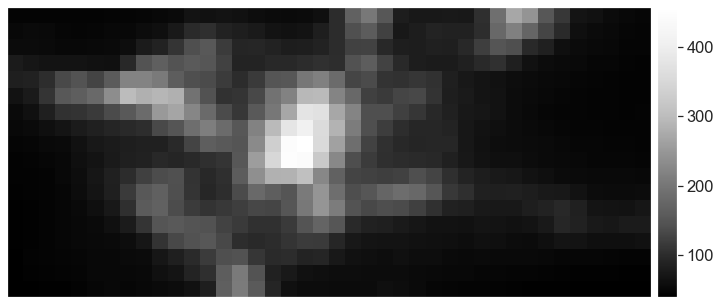

In [217]:
# Plot
ep.plot_bands(sept_2019_apr_2020_sundays_mean, scale=False,
              vmax=sept_2019_apr_2020_sundays_mean.max())

plt.show()

#### Mondays

In [218]:
# Get Mondays from Sept 2019 - April 2020
date_list = rd.create_date_list(
    '2019-09-01', '2020-04-30', date_frequency='W-MON')

In [219]:
# Get array for each date into list
sept_2019_apr_2020_mondays_arrays = rd.extract_data(
 radiance=radiance_sept_2018_may_2020, dates=date_list)

In [220]:
# Confirm length
len(sept_2019_apr_2020_mondays_arrays)

35

In [221]:
# Calculate mean
sept_2019_apr_2020_mondays_mean = rd.calculate_mean(
    sept_2019_apr_2020_mondays_arrays)

In [222]:
# Get min and max values for mean
print(f"Min: {sept_2019_apr_2020_mondays_mean.min()}")
print(f"Max: {sept_2019_apr_2020_mondays_mean.max()}")

Min: 31.233333333333334
Max: 455.3666666666667


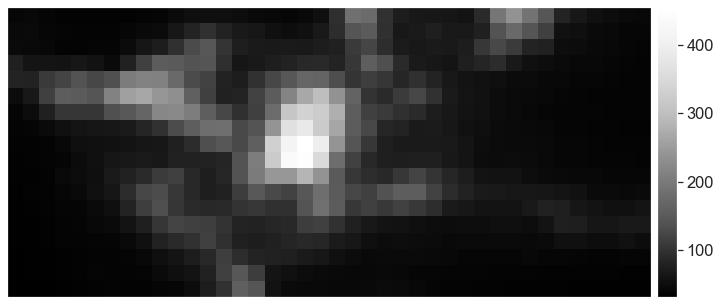

In [223]:
# Plot
ep.plot_bands(sept_2019_apr_2020_mondays_mean, scale=False,
              vmax=sept_2019_apr_2020_mondays_mean.max())

plt.show()

#### Business Days

In [224]:
# Get business days, March 2020
date_list = rd.create_date_list('2020-03-01', '2020-03-14', date_frequency='B')

In [228]:
# Get array for each date into list
march_2020_business_arrays = rd.extract_data(
 radiance=radiance_sept_2018_may_2020, dates=date_list)

In [229]:
# Confirm length
len(march_2020_business_arrays)

10

In [230]:
# Calculate mean
march_2020_business_mean = rd.calculate_mean(march_2020_business_arrays)

In [231]:
# Get min and max values for mean
print(f"Min: {march_2020_business_mean.min()}")
print(f"Max: {march_2020_business_mean.max()}")

Min: 42.8
Max: 592.9


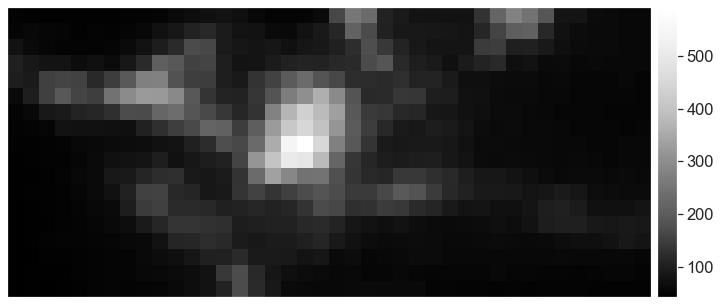

In [232]:
# Plot
ep.plot_bands(march_2020_business_mean, scale=False,
              vmax=march_2020_business_mean.max())

plt.show()

## Data Visualization

### Plot Cloud Free Mean Radiance Values for September 2019

NameError: name 'sept_2019_radiance_mean' is not defined

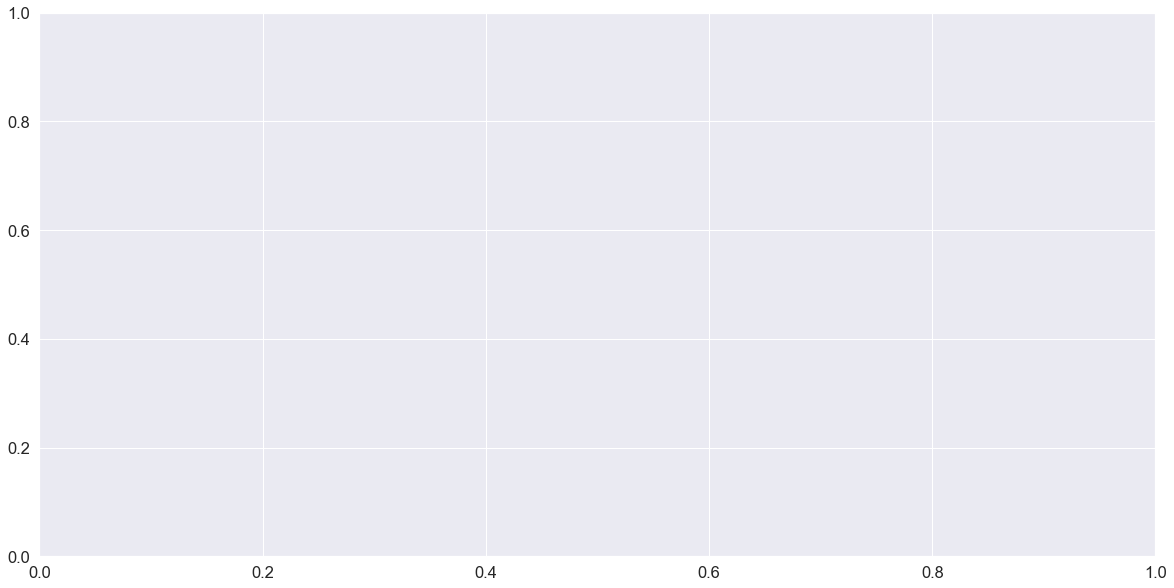

In [233]:
# Create figure and axes object
fig, ax = plt.subplots(figsize=(20, 10))

# Plot radiance values
ep.plot_bands(
    sept_2019_radiance_mean,
    title="September 2019 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    #cmap='Greens_r',
    scale=False,
    extent=psu_extent, 
    ax=ax,
    vmax=sept_2019_radiance_mean.max())

# Plot lat/lon (centroids)
# psu_lat_lon_gdf.plot(ax=ax)

plt.show()

In [234]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        sept_2019_radiance_mean,
        hist_range=(0, sept_2019_radiance_mean.max()),
        colors='#984ea3',
        title='Distribution of the Mean Radiance (September 2019)',
        xlabel='Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', 
        ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

    plt.show()

NameError: name 'sept_2019_radiance_mean' is not defined

### Plot Cloud Free Mean Radiance Values for March 2020

In [ ]:
# Create figure and axes object
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(
    march_2020_radiance_mean,
    title="March 2020 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    #cmap='Greens_r',
    scale=False,
    extent=psu_extent, 
    ax=ax, 
    vmax=sept_2019_radiance_mean.max())

plt.show()

In [ ]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        march_2020_radiance_mean,
        hist_range=(0, sept_2019_radiance_mean.max()),
        colors='#984ea3',
        title='Distribution of the Mean Radiance (March 2020)',
        xlabel='Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)',
        ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

    plt.show()

### Plot Cloud Free Change in Mean Radiance Values from September 2019 to March 2020

In [ ]:
# Plot change in radiance values
ep.plot_bands(
    diff_sept_2019_march_2020, 
    title="Difference in Mean Radiance (March 2020 - September 2019)",
    cmap='RdBu_r',
    figsize=(20, 10),
    scale=False,
    vmin=diff_sept_2019_march_2020.min(),
    vmax=-diff_sept_2019_march_2020.min(),
    extent=psu_extent)

plt.show()

In [ ]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        diff_sept_2019_march_2020,
        hist_range=(diff_sept_2019_march_2020.min(), -diff_sept_2019_march_2020.min()),
        colors='#984ea3',
        title='Distribution of the Change in Mean Radiance (September 2019 vs. March 2020)',
        xlabel='Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

### Combined Plots

NameError: name 'sept_2019_radiance_mean' is not defined

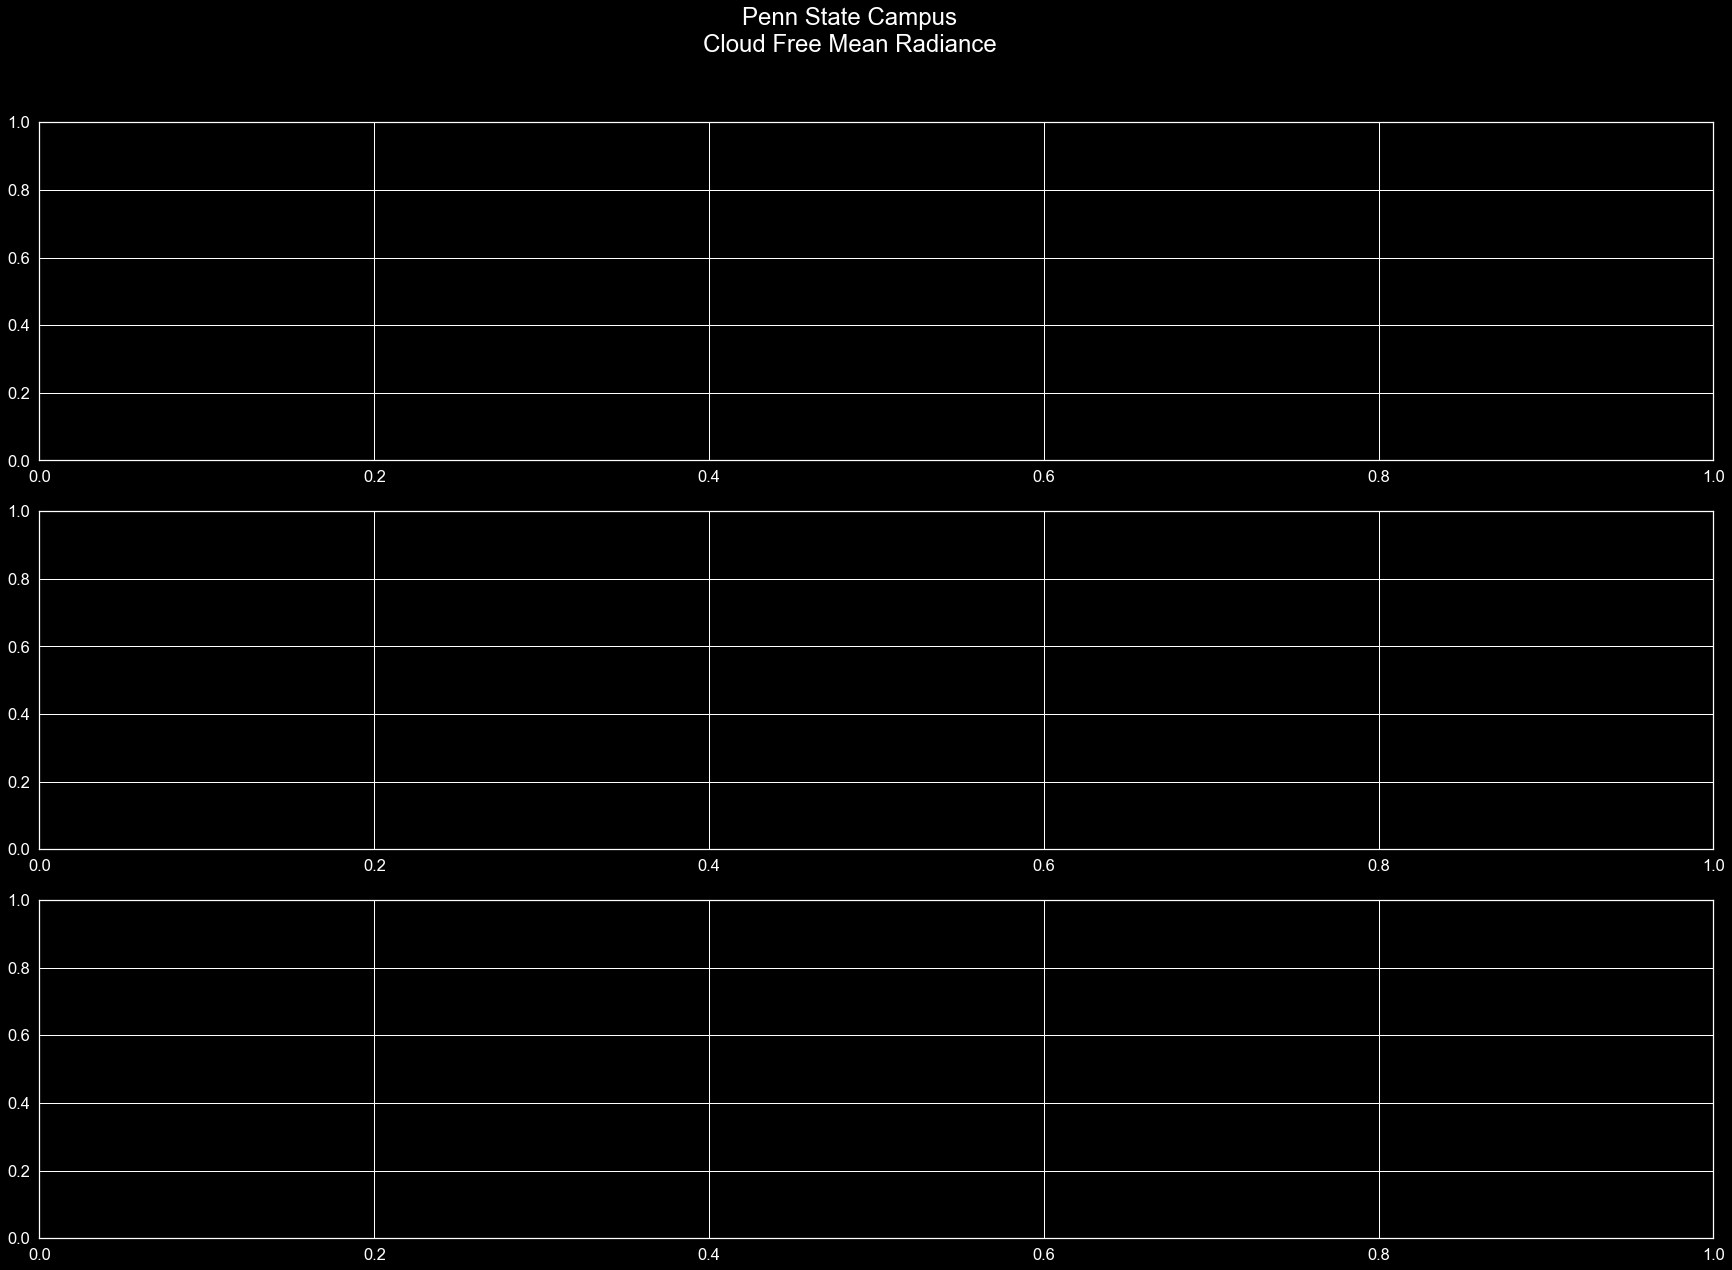

In [235]:
# Plot
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(3, 1, figsize=(30, 20))

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    plt.subplots_adjust(hspace=0.15)
    plt.subplots_adjust(top=0.9)

    ep.plot_bands(
        sept_2019_radiance_mean, title="September 2019 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        scale=False,
        vmax=sept_2019_radiance_mean.max(),
        ax=ax[0],
        extent=psu_extent)

    ep.plot_bands(
        march_2020_radiance_mean, title="March 2020 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        scale=False,
        vmax=sept_2019_radiance_mean.max(),
        ax=ax[1],
        extent=psu_extent)

    ep.plot_bands(
        diff_sept_2019_march_2020, title="Change in Mean Radiance (September 2019 vs. March 2020) ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        cmap='RdBu_r',
        scale=False,
        vmin=diff_sept_2019_march_2020.min(),
        vmax=-diff_sept_2019_march_2020.min(),
        ax=ax[2],
        extent=psu_extent)

    # Add caption
    fig.text(0.5, .1, "Data Source: NASA Black Marble",
             ha='center', fontsize=16)
    
    ax[0].title.set_size(20)
    ax[1].title.set_size(20)
    ax[2].title.set_size(20)

plt.savefig(
    fname="penn-state-mean-radiance-change-sept2019-mar2020-values.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        diff_sept_2019_march_2020,
        #         bins=40,
        hist_range=(diff_sept_2019_march_2020.min(), -diff_sept_2019_march_2020.min()),
        colors='#984ea3',
        title='Distribution of the Change in Mean Radiance (September 2019 vs. March 2020)',
        xlabel='Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

plt.savefig(
    fname="penn-state-mean-radiance-change-sept2019-mar2020-histogram.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')

## Data Export - No Padding to Export Origin

In [ ]:
# Define export output paths
sept_2019_radiance_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-sept2019.tif")

march_2020_radiance_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-march2020.tif")

radiance_diff_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-difference-sept2019-march2020.tif")

In [ ]:
# Define export transform
transform = from_origin(lon_min, lat_max, coord_spacing, coord_spacing)

# Define export metadata
psu_campus_metadata = {
    "driver": "GTiff",
    "dtype": diff_sept_2019_march_2020.dtype,
    "nodata": 0,
    "width": diff_sept_2019_march_2020.shape[1],
    "height": diff_sept_2019_march_2020.shape[0],
    "count": 1,
    "crs": psu_lat_lon_gdf.crs,  # +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs
    "transform": transform
}

In [ ]:
# Export September 2019 radiance
rd.export_array(
    array=sept_2019_radiance_mean,
    output_path=sept_2019_radiance_outpath,
    metadata=psu_campus_metadata)

# Export March 2020 radiance
rd.export_array(
    array=march_2020_radiance_mean,
    output_path=march_2020_radiance_outpath,
    metadata=psu_campus_metadata)

# Export radiance difference
rd.export_array(
    array=diff_sept_2019_march_2020,
    output_path=radiance_diff_outpath,
    metadata=psu_campus_metadata)

## Data Export - Yes Padding to Export Origin (Upper left corner .vs upper left centroid)

In [ ]:
# Define export output paths
sept_2019_radiance_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-sept2019-pad.tif")

march_2020_radiance_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-march2020-pad.tif")

radiance_diff_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-difference-sept2019-march2020-pad.tif")

In [263]:
# Coords for export, West-most and North-most (coords of top-lef pixel)
export_west_coord = psu_extent[0]
export_north_coord = psu_extent[3]

# Define export transform
transform = from_origin(
    export_west_coord, export_north_coord, coord_spacing, coord_spacing)

# Define export metadata
psu_campus_metadata = {
    "driver": "GTiff",
    "dtype": diff_sept_2019_march_2020.dtype,
    "nodata": 0,
    "width": diff_sept_2019_march_2020.shape[1],
    "height": diff_sept_2019_march_2020.shape[0],
    "count": 1,
    "crs": psu_lat_lon_gdf.crs,  # +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs
    "transform": transform
}


def create_metadata(array, transform, driver='GTiff', nodata=0, count=1, crs="epsg:4326"):
    """Creates export metadata, for use with
    exporting an array to raster format.
    
    Parameters
    ----------
    array : numpy array
        Array containing data for export.
    
    transform : rasterio.transform affine object
        Affine transformation for the georeferenced array.
        
    driver : str
        File type/format for export. Defaults to GeoTiff ('GTiff').
    
    nodata : int or float
        Value in the array indicating no data. Defaults to 0.
    
    count : int
        Number of bands in the array for export. Defaults to 1.
        
    crs : str
        Coordinate reference system for the georeferenced 
        array. Defaults to EPSG 4326 ('epsg:4326').
    
    Returns
    -------
    metadata : dict
        Dictionary containing the export metadata.
    
    Example
    -------
        >>> # Imports
        >>> import numpy as np
        >>> from rasterio.transform import from_origin
        >>> # Create array
        >>> arr = np.array([[1,2],[3,4]])
        >>> transform = from_origin(-73.0, 43.0, 0.5, 0.5)
        >>> meta = create_metadata(arr, transform)  
        # Display metadata
        >>> meta
        {'driver': 'GTiff',
         'dtype': dtype('int32'),
         'nodata': 0,
         'width': 2,
         'height': 2,
         'count': 1,
         'crs': 'epsg:4326',
         'transform': Affine(0.5, 0.0, -73.0,
                0.0, -0.5, 43.0)}  
    """
    # Define metadata
    metadata = {
        "driver": driver,
        "dtype": array.dtype,
        "nodata": nodata,
        "width": array.shape[1],
        "height": array.shape[0],
        "count": count,
        "crs": crs,
        "transform": transform
    }
    
    # Return metadata
    return metadata

In [ ]:
# Determine # of bands (1 vs many)
count = 1 if len(array.shape) == 2 else array.shape[0]

# (bands, rows, columns)

In [279]:
arr = np.array([[1,2],[3,4]])

metadata = {
        "driver": "GTiff",
        "dtype": arr.dtype,
        "nodata": 0,
        "width": arr.shape[1],
        "height": arr.shape[0],
        "count": 1,
        "crs": "epsg:4326",
        "transform": from_origin(-73.0, 43.0, 0.5, 0.5)
}
metadata


{'driver': 'GTiff',
 'dtype': dtype('int32'),
 'nodata': 0,
 'width': 2,
 'height': 2,
 'count': 1,
 'crs': 'epsg:4326',
 'transform': Affine(0.5, 0.0, -73.0,
        0.0, -0.5, 43.0)}

In [ ]:
# Export September 2019 radiance
rd.export_array(
    array=sept_2019_radiance_mean,
    output_path=sept_2019_radiance_outpath,
    metadata=psu_campus_metadata)

# Export March 2020 radiance
rd.export_array(
    array=march_2020_radiance_mean,
    output_path=march_2020_radiance_outpath,
    metadata=psu_campus_metadata)

# Export radiance difference
rd.export_array(
    array=diff_sept_2019_march_2020,
    output_path=radiance_diff_outpath,
    metadata=psu_campus_metadata)

## Plotting Array with Cell Lat/Lon Points

#### Centroids

In [236]:
# # Lat/lon is CENTER of pixel
# Define extent
psu_extent = (
    lon_min - coord_spacing/2,
    lon_max + coord_spacing/2,
    lat_min - coord_spacing/2,
    lat_max + coord_spacing/2
)

fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
              #cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              cmap='RdBu_r',
              #figsize=(20,10),
              scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
              extent=psu_extent, ax=ax)#, vmax=1000)

psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# ax.set_axis_on()

plt.show()

NameError: name 'lon_min' is not defined

### Not Centroids

Possibly would have to add data to the geodataframe if the data showed top left, to get it to match up?

How to get it to match top-left of array cell?

In [256]:
psu_lat_lon_gdf

,ID,Latitude,Longitude,geometry
0,0,40.829917,-77.937355,POINT (-77.93736 40.82992)
1,1,40.825751,-77.937355,POINT (-77.93736 40.82575)
2,2,40.821584,-77.937355,POINT (-77.93736 40.82158)
3,3,40.817417,-77.937355,POINT (-77.93736 40.81742)
4,4,40.813251,-77.937355,POINT (-77.93736 40.81325)
5,5,40.809084,-77.937355,POINT (-77.93736 40.80908)
6,6,40.804917,-77.937355,POINT (-77.93736 40.80492)
7,7,40.800751,-77.937355,POINT (-77.93736 40.80075)
8,8,40.796584,-77.937355,POINT (-77.93736 40.79658)
9,9,40.792417,-77.937355,POINT (-77.93736 40.79242)


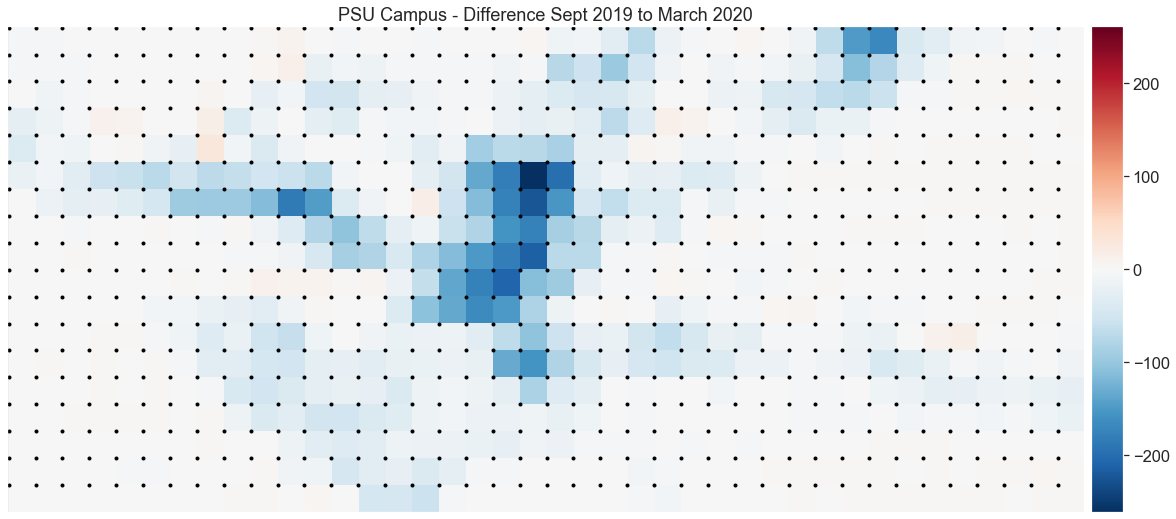

In [257]:
# Lat/lon is TOP-LEFT corner of pixel
psu_extent = (
    lon_min, # - coord_spacing,
    lon_max + coord_spacing,
    lat_min - coord_spacing,
    lat_max# + coord_spacing
)
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
              #cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              cmap='RdBu_r',
              #figsize=(20,10),
              scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
              extent=psu_extent, ax=ax)#, vmax=1000)

psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# ax.set_axis_on()

plt.show()

In [ ]:
# Lat/lon is TOP-RIGHT corner of pixel
psu_extent = (
    lon_min - coord_spacing,
    lon_max, # + coord_spacing,
    lat_min - coord_spacing,
    lat_max# + coord_spacing
)
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
              #cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              cmap='RdBu_r',
              #figsize=(20,10),
              scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
              extent=psu_extent, ax=ax)#, vmax=1000)

psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# ax.set_axis_on()

plt.show()

In [ ]:
# Lat/lon is BOTTOM-RIGHT corner of pixel
psu_extent = (
    lon_min - coord_spacing,
    lon_max, # + coord_spacing,
    lat_min, # - coord_spacing,
    lat_max + coord_spacing
)
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
              #cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              cmap='RdBu_r',
              #figsize=(20,10),
              scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
              extent=psu_extent, ax=ax)#, vmax=1000)

psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# ax.set_axis_on()

plt.show()

In [ ]:
# Lat/lon is BOTTOM-LEFT corner of pixel
psu_extent = (
    lon_min, # - coord_spacing,
    lon_max + coord_spacing,
    lat_min, # - coord_spacing,
    lat_max + coord_spacing
)
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
              #cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              cmap='RdBu_r',
              #figsize=(20,10),
              scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
              extent=psu_extent, ax=ax)#, vmax=1000)

psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# ax.set_axis_on()

plt.show()

### Non-Rounded Coord Spacing

In [ ]:
# # Lat/lon is CENTER of pixel
# Define extent
psu_extent = (
    lon_min - lon_spacing/2,
    lon_max + lon_spacing/2,
    lat_min - lat_spacing/2,
    lat_max + lat_spacing/2
)

fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
              #cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              cmap='RdBu_r',
              #figsize=(20,10),
              scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
              extent=psu_extent, ax=ax)#, vmax=1000)

psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# ax.set_axis_on()

plt.show()

In [ ]:
# Lat/lon is TOP-LEFT corner of pixel
psu_extent = (
    lon_min, # - coord_spacing,
    lon_max + lon_spacing,
    lat_min - lat_spacing,
    lat_max# + coord_spacing
)
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
              #cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              cmap='RdBu_r',
              #figsize=(20,10),
              scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
              extent=psu_extent, ax=ax)#, vmax=1000)

psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# ax.set_axis_on()

plt.show()

In [ ]:
# Lat/lon is TOP-RIGHT corner of pixel
psu_extent = (
    lon_min - lon_spacing,
    lon_max, # + coord_spacing,
    lat_min - lat_spacing,
    lat_max# + coord_spacing
)
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
              #cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              cmap='RdBu_r',
              #figsize=(20,10),
              scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
              extent=psu_extent, ax=ax)#, vmax=1000)

psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# ax.set_axis_on()

plt.show()

In [ ]:
# Lat/lon is BOTTOM-RIGHT corner of pixel
psu_extent = (
    lon_min - lon_spacing,
    lon_max, # + coord_spacing,
    lat_min, # - coord_spacing,
    lat_max + lat_spacing
)
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
              #cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              cmap='RdBu_r',
              #figsize=(20,10),
              scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
              extent=psu_extent, ax=ax)#, vmax=1000)

psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# ax.set_axis_on()

plt.show()

In [ ]:
# Lat/lon is BOTTOM-LEFT corner of pixel
psu_extent = (
    lon_min, # - coord_spacing,
    lon_max + lon_spacing,
    lat_min, # - coord_spacing,
    lat_max + lat_spacing
)
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
              #cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              cmap='RdBu_r',
              #figsize=(20,10),
              scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
              extent=psu_extent, ax=ax)#, vmax=1000)

psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# ax.set_axis_on()

plt.show()